In [11]:
import pickle
import pandas as pd
import numpy as np


from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import validation_curve

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score


import matplotlib.pyplot as plt
import seaborn as sns


Imports

In [12]:
# df.to_feather(r'data/houses.feather')
X_train = pd.read_feather("data_model/X_train.feather")
y_train = pd.read_feather("data_model/y_train.feather")
X_test = pd.read_feather("data_model/X_test.feather")
y_test = pd.read_feather("data_model/y_test.feather")

# Convertit y en Series 1d
y_train = y_train.iloc[:,0]
y_test  = y_test.iloc[:,0]


In [13]:

X_train.head(1)

,sq_mt_built,n_rooms,n_bathrooms,neighborhood,has_lift,has_parking,has_pool,has_garden,has_storage_room,is_floor_under
0,95.0,2.0,2.0,129.0,1.0,1.0,1.0,0.0,1.0,0.0


In [14]:
print(f"X_train : {X_train.shape}\ny_train : {y_train.shape}")

X_train : (17163, 10)
y_train : (17163,)


### Modele de base - Dummy Regressor

In [15]:
dummy = DummyRegressor(strategy="median")
dummy.fit(X_train, y_train)

y_pred = dummy.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Dummy Regressor Performance:\nR²: {r2:.4f}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}")

Dummy Regressor Performance:
R²: -0.0121
RMSE: 0.92
MAE: 0.75


### Regression Linéaire

In [16]:

lr = LinearRegression()
lr.fit(X_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [17]:
lr.score(X_train, y_train)

0.7551590782053541

In [18]:
lr.score(X_test, y_test)

0.747595897391184

In [19]:
# scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='r2')
# print("R² CV moyenne :", scores.mean())


In [20]:
# Génère des prédictions par validation croisée  (X_train uniquement)
y_train_pred = cross_val_predict(lr, X_train, y_train, cv=5)

# Calcul les résidus ( .flatten() force le format 1D)
y_train_flat = y_train.values.flatten()
residuals = y_train_flat - y_train_pred.flatten()

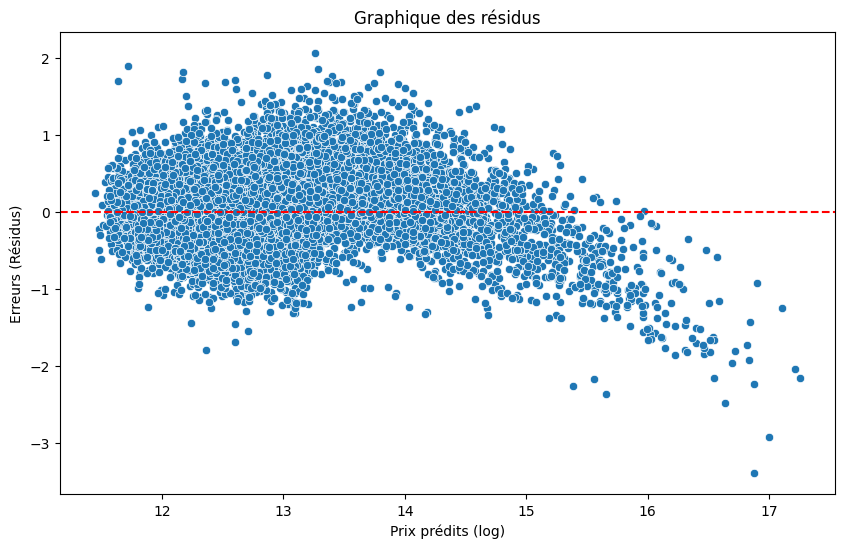

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train_pred.ravel(), y=residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Ligne horizontale à 0
plt.title('Graphique des résidus')
plt.xlabel('Prix prédits (log)')
plt.ylabel('Erreurs (Résidus)')
plt.show()

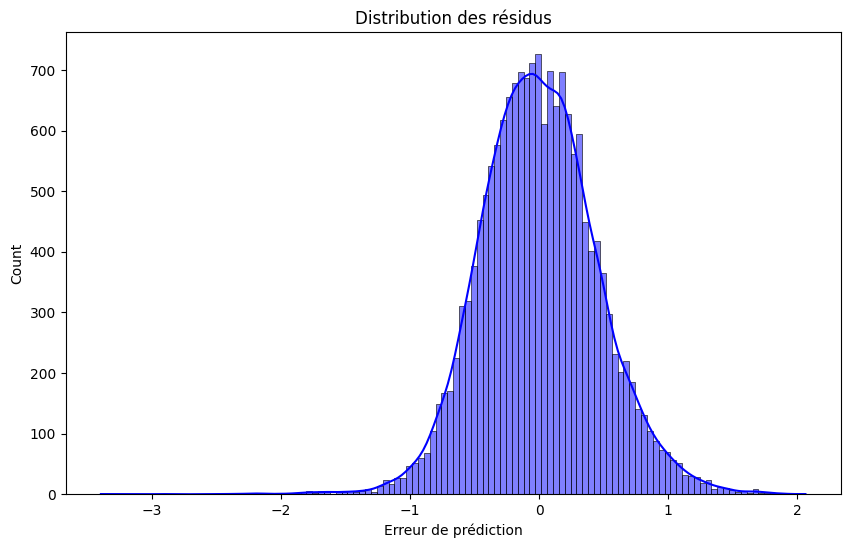

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Distribution des résidus')
plt.xlabel('Erreur de prédiction')
plt.show()

In [23]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

0.9907356306325819

In [24]:
rf_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
print("R² CV moyenne :", rf_scores.mean())

R² CV moyenne : 0.9433879838394004


Détection d'over fitting avec validation_curve

In [25]:
# De 10 à 200 arbres, par pas de 10
param_range = np.arange(10, 200, 10)

# détection d'overfitting avec validation_curve
train_score, val_score = validation_curve(
    rf, X_train, y_train, "n_estimators", param_range, cv=5)

# Autres paramètres possibles :
# max_depth : profondeur max des arbres (limite l'overfitting)
# min_samples_split : nombre min d'échantillons pour créer une split

plt.plot(param_range, val_score.mean(axis=1), label="Validation Score")
plt.plot(param_range, train_score.mean(axis=1), label="Training Score")
plt.ylabel("Score R²")
plt.xlabel("Number of Trees (N_estimators)")
plt.legend()
plt.grid(True, alpha=0.3)

TypeError: too many positional arguments

In [ ]:
# # 49 valeurs
# k = np.arrange(1,50)
# # 49 valeurs sont testées avec cv=5
# train_score, val_score = validation_curve(model, X_train, y_train, 'n_neighbors', k, cv=5)

## CI DESSOUS : COPILOT

## Validation croisée et comparaison de modèles
Nous comparons plusieurs modèles via une validation croisée (5-fold) avec deux métriques: R² (à maximiser) et MAE (à minimiser).
Ensuite, nous ajustons chaque modèle sur l'ensemble d'entraînement et reportons les performances sur le test set pour vérifier la généralisation.

In [27]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

# Prépare y_train en 1D si nécessaire
# y_train_vec = y_train.squeeze()

models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.001, max_iter=5000),
    'RandomForest': RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

rows = []
rf_model = None  # Variable pour garder le modèle RandomForest
for name, mdl in models.items():
    # R² en CV
    # cv_r2 = cross_val_score(mdl, X_train, y_train_vec, cv=cv, scoring='r2').mean()
    cv_r2 = cross_val_score(mdl, X_train, y_train, cv=cv, scoring='r2').mean()
    # MAE en CV (valeur positive)
    # cv_mae = -cross_val_score(mdl, X_train, y_train_vec, cv=cv, scoring='neg_mean_absolute_error').mean()
    cv_mae = -cross_val_score(mdl, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error').mean()
    
    # Fit et métriques sur test
    # mdl.fit(X_train, y_train_vec)
    mdl.fit(X_train, y_train)
    r2_test = mdl.score(X_test, y_test)
    y_pred_test = mdl.predict(X_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    
    # Garder le modèle RandomForest
    if name == 'RandomForest':
        rf_model = mdl
    
    rows.append({
        'model': name,
        'cv_r2': cv_r2,
        'cv_mae': cv_mae,
        'test_r2': r2_test,
        'test_mae': mae_test
    })

results_df = pd.DataFrame(rows).sort_values(by=['cv_r2'], ascending=False)
results_df

,model,cv_r2,cv_mae,test_r2,test_mae
3,RandomForest,0.943677,0.153619,0.947584,0.148733
1,Ridge,0.754610,0.354995,0.747596,0.360167
0,LinearRegression,0.754610,0.354984,0.747596,0.360159
2,Lasso,0.754541,0.355318,0.747497,0.360499


In [29]:
# Sauvegarder le modèle RandomForest
with open("models/random_forest_model.pkl", "wb") as f:
    pickle.dump(rf_model, f)

print("✅ Modèle RandomForest créé : models/random_forest_model.pkl")

✅ Modèle RandomForest créé : models/random_forest_model.pkl
